In [309]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import unidecode
import numpy as np

In [310]:
src1 = pathlib.Path().cwd().parent.parent / 'data' / 'external' / 'death-data'
src2 = pathlib.Path().cwd().parent.parent / 'data' / 'processed' / 'no-case-by-group'
ref = pathlib.Path().cwd().parent.parent / 'reference'

In [395]:
raw = pd.read_excel(src1 / 'death-data-2021-08-21.xlsx', skiprows=2)
pop = pd.read_csv(ref / 'pop_1.csv', sep=',', dtype={'id_addiv': 'str'})
addiv = pd.read_csv(ref / 'addiv.csv', sep=',', dtype={'id_addiv': 'str', 'of_addiv': 'str'})
no_case_by_ag = pd.read_csv(src2 / 'no-case-by-ag.csv')
no_case_by_sex = pd.read_csv(src2 / 'no-case-by-sex.csv')

In [312]:
# raw
# no_case_by_ag

In [313]:
def preprocess_string(row):
    s = unidecode.unidecode(row).upper().strip()
    return s

def get_no_death(data_in, pop=10000000, rolling=7):
    # Default population 10 000 000
    df = (
        data_in[['date_report']]
        .groupby(['date_report'])
        .apply(lambda x: len(x))
        .to_frame(name='no_death')
        .reindex(pd.date_range(start=data_in.date_report.min(), end=data_in.date_report.max(), freq='D'))
        .fillna(0)
    )
    df['pop'] = pop
    df['no_death_ppop'] = round(df['no_death'] /df['pop'] * 100000, 3)
    df = df.drop(columns='pop')
    name = str(rolling) + 'd'
    df['no_death_rollmean' + name ] = df.no_death.rolling(7).mean()
    df['no_death_ppop_rmean' + name] = df.no_death_ppop.rolling(7).mean()
    df['no_death_cumsum'] = df.no_death.cumsum()
    df['no_death_ppop_cumsum'] = df.no_death_ppop.cumsum()
    return df

def get_no_death_by_group(data_in, group=[], rolling=7, 
                         available_pop=False, getname=False):
    # WARNING list of group
    # Require global var pop, global addiv
    unique = data_in[group[0]].unique()
    # get no_death
    df_1 = (
        data_in[['date_report', group[0]]]
        .groupby(['date_report', group[0]])
        .apply(lambda x: len(x))
        .to_frame(name='no_death')
        .unstack(fill_value=0)
        .asfreq('D', fill_value=0)
        .stack()
        .sort_index(level=0)
        .reset_index()
    )
    # pivot
    df_pv = (
        df_1[['date_report', group[0], 'no_death']]
        .pivot(index='date_report', columns=group[0], values='no_death')
    ).fillna(0)
    # fill missing date with 0
    df_2 = (
        df_pv.reindex(pd.date_range(
            start=df_pv.index.min(),
            end=df_pv.index.max(),
            freq='D'))
        .fillna(0)
        .stack(list(range(0, len(group))))
        .reset_index()
        .rename(columns={
            'level_0': 'date_report',
            0: 'no_death'
        })
#         .set_index(['date_report'] + group)
    )
    
    # get no_death_rollmean
    df_3 = df_2
    name = str(rolling) + 'd'
    df_3['no_death_rollmean' + name] = (
        df_3.groupby(group)['no_death']
        .transform(lambda x: x.rolling(rolling).mean())
    )
    # get no_death cumsum
    df_3['no_death_cumsum'] = (
    df_3[['date_report', group[0], 'no_death']]
    .groupby(['date_report', group[0]]).sum()
    .groupby(level=1).cumsum().reset_index()
    ['no_death']
    )
    
    # Get no_death per population
    if available_pop:
        df_pop = pop[['id_addiv', 'pop']]
        df_3 = (
            df_3.merge(
                df_pop,
                how= 'left',
                left_on=group[0],
                right_on= 'id_addiv')
            .drop(columns=['id_addiv'])
        )
        
        df_3['no_death_ppop'] = df_3['no_death'] / df_3['pop'] * 100000
        df_3 = df_3.drop(columns='pop')
        name = str(rolling) + 'd'
        df_3['no_death_ppop_rollmean' + name] = (
            df_3.groupby(group)['no_death_ppop']
            .transform(lambda x: x.rolling(rolling).mean())
        )
        df_3['no_death_ppop_cumsum'] = (
        df_3[['date_report', group[0], 'no_death_ppop']]
            .groupby(['date_report', group[0]]).sum()
            .groupby(level=1).cumsum().reset_index()
            ['no_death_ppop']
        )
    

    # Get district name (optional)
    if getname:
        df_3 = (
            df_3.merge(
                addiv[['id_addiv', 'name_addiv_2']],
                how = 'left',
                left_on = group[0],
                right_on = 'id_addiv'
            )
            .drop(columns=[group[0], 'id_addiv'])
            .rename(columns={'name_addiv_2': group[0]})
        )
    return df_3


In [314]:
df = raw.rename(columns={
    raw.columns[0]: 'no',
    raw.columns[1]: 'level',
    raw.columns[2]: 'id',
    raw.columns[3]: 'hospital',
    raw.columns[4]: 'name_full',
    raw.columns[5]: 'yob',
    raw.columns[6]: 'sex',
    raw.columns[7]: 'tel',
    raw.columns[8]: 'addr_home',
    raw.columns[9]: 'addr_ward_home',
    raw.columns[10]: 'addr_dist_home',
    raw.columns[11]: 'from',
    raw.columns[12]: 'test_result',
    raw.columns[13]: 'ct',
    raw.columns[14]: 'diagnosis',
    raw.columns[15]: 'date_admit',
    raw.columns[16]: 'date_report',
    raw.columns[17]: 'status',
})

df = df[['date_report', 'yob', 'sex', 'addr_dist_home']]

In [315]:
# pd.to_datetime(df.date_report.dt.date)

In [316]:
df['yob'] = pd.to_numeric(df.yob, errors='coerce')
df['sex'] = df.sex.astype('str').apply(preprocess_string)
df['addr_dist_home'] = df.addr_dist_home.astype('str').apply(preprocess_string)
df['age'] = 2021 - df['yob']
df['date_report'] = pd.to_datetime(df.date_report.dt.date)

# fix district name
df.loc[df.addr_dist_home == 'QUAN 1', 'adh'] = 'QUAN 01'
df.loc[df.addr_dist_home == 'QUAN 2', 'adh'] = 'QUAN 02'
df.loc[df.addr_dist_home == 'QUAN 3', 'adh'] = 'QUAN 03'
df.loc[df.addr_dist_home == 'QUAN 4', 'adh'] = 'QUAN 04'
df.loc[df.addr_dist_home == 'QUAN 5', 'adh'] = 'QUAN 05'
df.loc[df.addr_dist_home == 'QUAN 6', 'adh'] = 'QUAN 06'
df.loc[df.addr_dist_home == 'QUAN 7', 'adh'] = 'QUAN 07'
df.loc[df.addr_dist_home == 'QUAN 8', 'adh'] = 'QUAN 08'
df.loc[df.addr_dist_home == 'QUAN 9', 'adh'] = 'QUAN 09'

# Drop old col and replace by fixed col
df = df.drop(columns=['addr_dist_home'])
df = df.rename(columns={'adh': 'addr_dist_home'})

# Get age group
df['age_group'] = pd.cut(
    df.age,
    bins = [0, 17, 45, 65, 200],
    labels = ['0 - 16', '17 - 44', '45 - 64', '> 65'],
    right = False
)
df = df[(df.date_report >= '2021-05-27')
        & (df.date_report <= '2021-08-21')]

In [352]:
# df[df.age.notna()]
# df.age.unique()

In [318]:
pop_total = int(pop[pop.id_addiv == '79']['pop'][0])
no_death = get_no_death(df, pop=pop_total)

In [339]:
# no_death.loc['2021-05-31': '2021-08-21',]
# data_in.info()
# no_death

,no_death,no_death_ppop,no_death_rollmean7d,no_death_ppop_rmean7d,no_death_cumsum,no_death_ppop_cumsum
2021-06-07,1.0,0.011,NaN,NaN,1.0,0.011
2021-06-08,0.0,0.000,NaN,NaN,1.0,0.011
2021-06-09,0.0,0.000,NaN,NaN,1.0,0.011
2021-06-10,0.0,0.000,NaN,NaN,1.0,0.011
2021-06-11,0.0,0.000,NaN,NaN,1.0,0.011
...,...,...,...,...,...,...
2021-08-17,130.0,1.446,172.571429,1.919143,4560.0,50.705
2021-08-18,191.0,2.124,175.000000,1.946143,4751.0,52.829
2021-08-19,149.0,1.657,172.857143,1.922286,4900.0,54.486
2021-08-20,74.0,0.823,159.428571,1.773000,4974.0,55.309


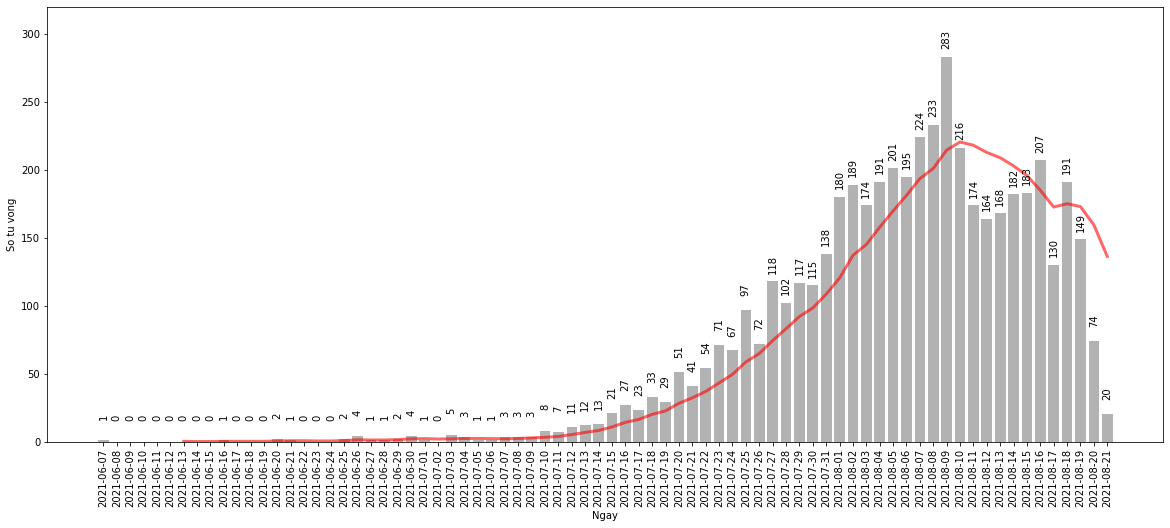

In [320]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i] + 20, y[i].astype('int'), ha='center', va='top', rotation=90)

# x = np.arange(len(list(data_in.index.astype('str'))))
# data_in = no_death.loc['2021-05-31': '2021-08-21',].reset_index()
# data_in.rename(columns={'index': 'date_report'}, inplace=True)
data_in = no_death.loc['2021-05-27': '2021-08-21',]
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(data_in.index, data_in.no_death, linewidth=3, color='gray', alpha=0.6)
ax.plot(data_in.index, data_in.no_death_rollmean7d, linewidth=3, color='red', alpha=0.6)
ax.set_ylabel('So tu vong')
ax.set_ylim([0, 320])
ax.set_xlabel('Ngay')
ax.set_xticks(data_in.index)
ax.tick_params(axis='x', labelrotation=90)
addlabels(data_in.index, data_in.no_death)

In [334]:
# data_in.index
# no_death_by_ag

,date_report,age_group,no_death,no_death_rollmean7d,no_death_cumsum
0,2021-06-07,0 - 16,0,NaN,0
1,2021-06-07,17 - 44,0,NaN,0
2,2021-06-07,45 - 64,1,NaN,1
3,2021-06-07,> 65,0,NaN,0
4,2021-06-08,0 - 16,0,NaN,0
...,...,...,...,...,...
299,2021-08-20,> 65,35,81.000000,2484
300,2021-08-21,0 - 16,0,0.285714,10
301,2021-08-21,17 - 44,2,12.142857,445
302,2021-08-21,45 - 64,10,55.285714,2028


In [351]:
# %% Get no death by age group
data_in_get_no_death_by_group_ag = (
    df[df.age.notna()]
)
no_death_by_ag = get_no_death_by_group(
    data_in_get_no_death_by_group_ag,
    group=['age_group'],
    available_pop=False,
    getname=False)

# no_death_by_ag = no_death_by_ag[(no_death_by_ag.date_report >= '2021-05-27')
#                                 & (no_death_by_ag.date_report <= '2021-08-21')]

no_death_by_ag['date_report'] = no_death_by_ag['date_report'].astype('str')
no_death_by_ag['age_group'] = no_death_by_ag['age_group'].astype('str')

In [357]:
# %% Get no death by sex
data_in_get_no_death_by_group_sex = (
    df[df.sex != 'NAN']
)
no_death_by_sex = get_no_death_by_group(
    data_in_get_no_death_by_group_sex,
    group=['sex'],
    available_pop=False,
    getname=False)

no_death_by_sex['date_report'] = no_death_by_sex['date_report'].astype('str')
no_death_by_sex['sex'] = no_death_by_sex['sex'].astype('str')

In [388]:
# %% Get incidence by sex, age group
data_in_get_no_death_by_group_sex_ag = (
    df[(df.sex != 'NAN') & (df.age.notna())]
)
data_in_get_no_death_by_group_sex_ag['sex_ag'] = (
    data_in_get_no_death_by_group_sex_ag['sex'].astype('str') + "_" + data_in_get_no_death_by_group_sex_ag['age_group'].astype('str')
)
no_death_by_sex_ag = get_no_death_by_group(
    data_in_get_no_death_by_group_sex_ag,
    group=['sex_ag'],
    available_pop=False,
    getname=False)

no_death_by_sex_ag['date_report'] = no_death_by_sex_ag['date_report'].astype('str')
no_death_by_sex_ag[['sex','age_group']] = no_death_by_sex_ag['sex_ag'].str.split('_',expand=True)
# no_death_by_sex['sex'] = no_death_by_sex['sex'].astype('str')

<ipython-input-388-a5915d52b1e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_in_get_no_death_by_group_sex_ag['sex_ag'] = (


In [392]:
no_death_by_sex_ag

,date_report,sex_ag,no_death,no_death_rollmean7d,no_death_cumsum,sex,age_group
0,2021-06-07,NAM_0 - 16,0,NaN,0,NAM,0 - 16
1,2021-06-07,NAM_17 - 44,0,NaN,0,NAM,17 - 44
2,2021-06-07,NAM_45 - 64,0,NaN,0,NAM,45 - 64
3,2021-06-07,NAM_> 65,0,NaN,0,NAM,> 65
4,2021-06-07,NU_0 - 16,0,NaN,0,NU,0 - 16
...,...,...,...,...,...,...,...
603,2021-08-21,NAM_> 65,2,25.857143,908,NAM,> 65
604,2021-08-21,NU_0 - 16,0,0.142857,3,NU,0 - 16
605,2021-08-21,NU_17 - 44,1,4.571429,189,NU,17 - 44
606,2021-08-21,NU_45 - 64,8,31.142857,1098,NU,45 - 64


In [393]:
no_case_no_death_by_ag = pd.merge(no_case_by_ag,
               no_death_by_ag,
               how='left',
               left_on=['date_report','age_group'], 
               right_on = ['date_report','age_group'])

no_case_no_death_by_ag['pct_death'] = no_case_no_death_by_ag['no_death'] / no_case_no_death_by_ag['no_case']
no_case_no_death_by_ag['pct_death_cumsum'] = no_case_no_death_by_ag['no_death_cumsum'] / no_case_no_death_by_ag['no_case_cumsum']

In [397]:
no_case_no_death_by_sex = pd.merge(no_case_by_sex,
               no_death_by_sex,
               how='left',
               left_on=['date_report','sex'], 
               right_on = ['date_report','sex'])

no_case_no_death_by_sex['pct_death'] = no_case_no_death_by_sex['no_death'] / no_case_no_death_by_sex['no_case']
no_case_no_death_by_sex['pct_death_cumsum'] = no_case_no_death_by_sex['no_death_cumsum'] / no_case_no_death_by_sex['no_case_cumsum']

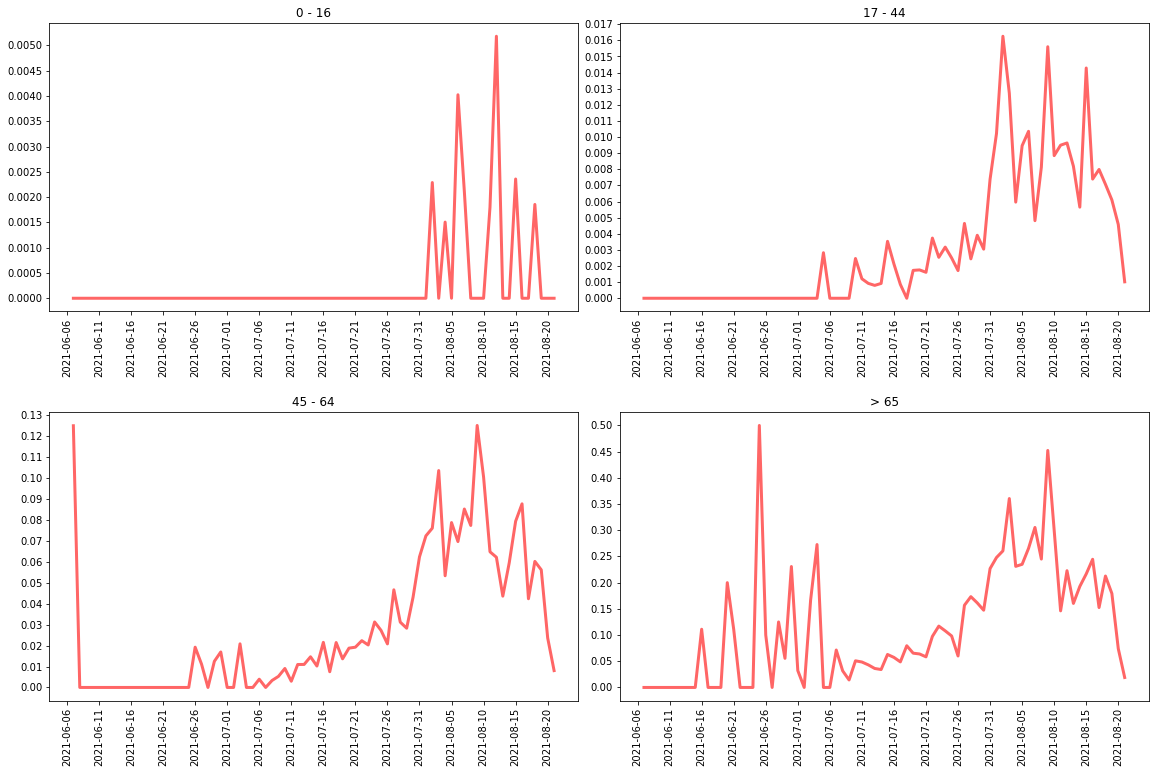

In [398]:
unique = list(no_case_no_death_by_ag['age_group'].unique())
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 10))
plt.tight_layout(h_pad=8)
for ind, val in enumerate(unique):
    r = ind // ncol
    c = ind % ncol
    data = no_case_no_death_by_ag[no_case_no_death_by_ag['age_group'] == val]
#     ax[r][c].bar(data['date_report'], data['no_death'], linewidth=3, color='gray', alpha=0.6)
    ax[r][c].plot(data['date_report'], data['pct_death'], linewidth=3, color='red', alpha=0.6)
    ax[r][c].set_xticks(data['date_report'])
    ax[r][c].set_xticklabels(data['date_report'])
    ax[r, c].tick_params(axis='x', labelrotation=90)
    ax[r, c].locator_params(tight=True, nbins=20)
    ax[r, c].title.set_text(val)
#     ax[r, c].set_ylim([0, 0.52])


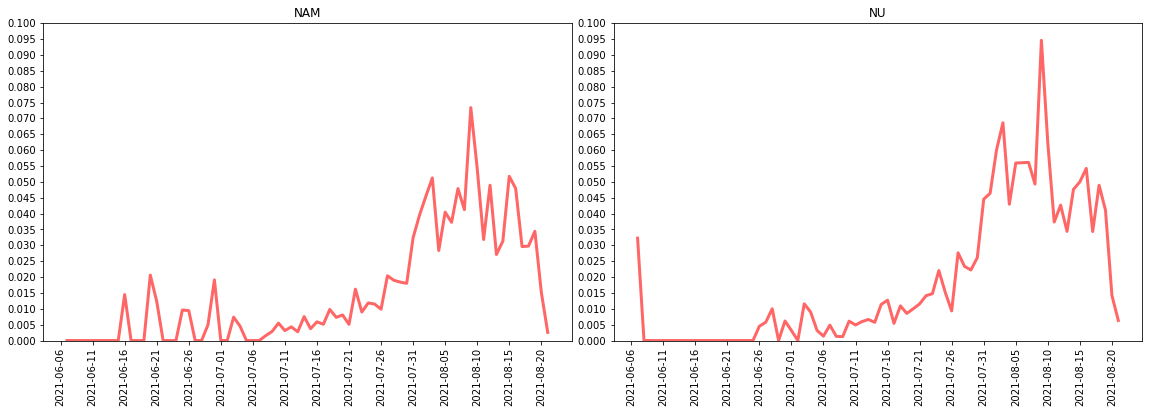

In [404]:
unique = list(no_case_no_death_by_sex['sex'].unique())
nrow = 1
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 5))
plt.tight_layout(h_pad=8)
for ind, val in enumerate(unique):
    c = ind % ncol
    data = no_case_no_death_by_sex[no_case_no_death_by_sex['sex'] == val]
#     ax[r][c].bar(data['date_report'], data['no_death'], linewidth=3, color='gray', alpha=0.6)
    ax[c].plot(data['date_report'], data['pct_death'], linewidth=3, color='red', alpha=0.6)
    ax[c].set_xticks(data['date_report'])
    ax[c].set_xticklabels(data['date_report'])
    ax[c].tick_params(axis='x', labelrotation=90)
    ax[c].locator_params(tight=True, nbins=20)
    ax[c].title.set_text(val)
    ax[c].set_ylim([0, 0.1])

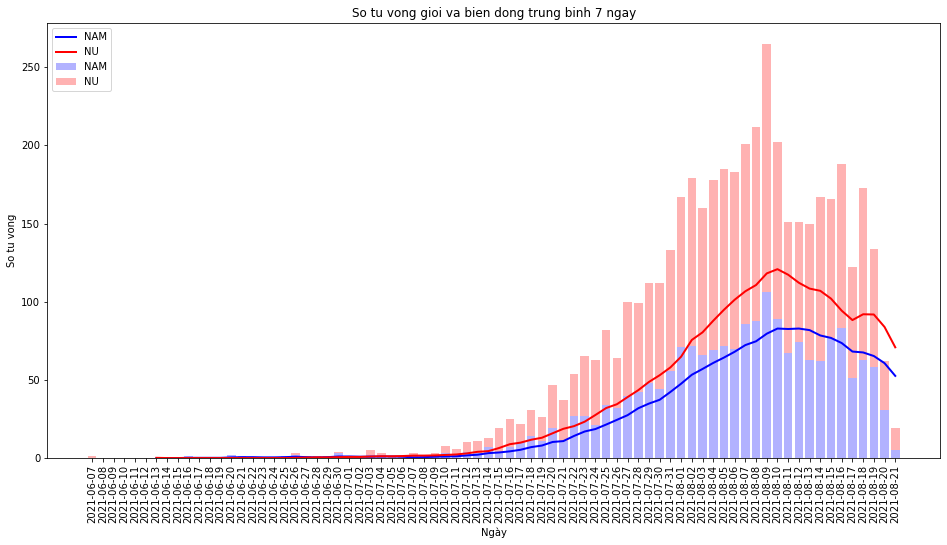

In [377]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 600, y[i], ha='center', va='top', rotation=90)

data1 = no_death_by_sex[no_death_by_sex.sex == 'NAM']
data2 = no_death_by_sex[no_death_by_sex.sex == 'NU']
fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(inc.index, inc.case, label='Số ca mới theo ngày', linewidth=3, color='gray')
ax.bar(data1.date_report, data1.no_death, label='NAM', color='blue', alpha=0.3)
ax.bar(data2.date_report, data2.no_death, bottom=data1.no_death, label='NU', color='red', alpha=0.3)
# ax.plot(inc.index, inc.case_rm, label='Biến động trung bình 7 ngày', linewidth=3, color='black')
ax.plot(data1.date_report, data1.no_death_rollmean7d, label='NAM', linewidth=2, color='blue')
ax.plot(data2.date_report, data2.no_death_rollmean7d, label='NU', linewidth=2, color='red')
ax.set_ylabel('So tu vong')
# ax.set_ylim([0, 7500])
ax.set_xlabel('Ngày')
ax.set_xticks(data1.date_report)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('So tu vong gioi va bien dong trung binh 7 ngay')
ax.legend(loc='upper left')
# addlabels(data1.date_report, inc.case)

In [376]:
data2.no_death

1        1
3        0
5        0
7        0
9        0
      ... 
143     71
145    110
147     76
149     31
151     14
Name: no_death, Length: 76, dtype: int64

['0 - 16', '17 - 44', '45 - 64', '> 65']

In [326]:
no_death_by_ag.to_csv(pathlib.Path().cwd().parent.parent / 'data' / 'processed' / 'no-death-by-group' / 'no-death-by-ag.csv')
no_death.to_csv(pathlib.Path().cwd().parent.parent / 'data' / 'processed' / 'no-death' / 'no-death.csv')
dfm.to_csv(pathlib.Path().cwd().parent.parent / 'data' / 'processed' / 'no-death-by-group' / 'no-case-no-death-by-ag.csv')
